In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import pyDOE

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 8) Joint distribution for wind energy with truncated Weibull

Analytical model for testing

In [2]:
def model(WS,sigma_WS,shear):
    CP = 0.45
    rho = 1.225
    D = 70.
    A = np.pi*D**2/4
    WS_rated = 15.
    P_rated = 3.6e6
    
    TI = sigma_WS/WS
    CP_TI = CP*( 1./(TI+1.) )*( 0.5*special.erf( 3. - (1.*WS/WS_rated) ) + 0.5 )
    WS_eq = WS*( (TI+1.)**3. ) * ( 1. - 0.15*np.cos( shear*np.pi/0.4 ) )
    
    P = CP_TI*0.5*rho*A*(WS_eq)**3.
    return (P/P_rated)*(P<P_rated)*(P>3.) + (1.)*(P>=P_rated) + 0.*(P<=3.)


Polynomial fit of the normal turbulence model (NTM) [IEC 61400 2015]

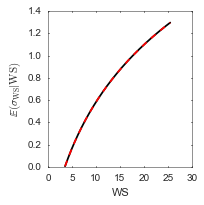

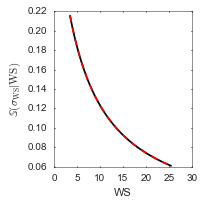

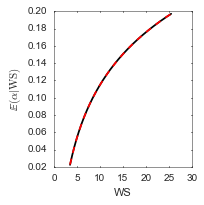

In [3]:
WS_rng = np.linspace(3.5,25.5,1000,endpoint=True)
I_ref = .16
S_sigma = (np.log( 1. + (1.4)**2./(0.75*WS_rng + 3.8)**2.))**0.5
E_sigma = np.log( I_ref*(0.75*WS_rng + 3.8) ) - S_sigma**2./2

E_sigma_pfit = np.poly1d(np.polyfit(WS_rng,E_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,E_sigma,'k')
ax.plot(WS_rng,E_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

S_sigma_pfit = np.poly1d(np.polyfit(WS_rng,S_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,S_sigma,'k')
ax.plot(WS_rng,S_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{S}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

mu_shear = 0.088*(np.log(WS_rng)-1.)

E_a = np.poly1d(np.polyfit(WS_rng,mu_shear,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,mu_shear,'k')
ax.plot(WS_rng,E_a(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\alpha|\mathrm{WS})$')
fig.tight_layout()




### 0) Joint distribution 

In [4]:
Weibull_truncated = cp.construct(
     cdf=lambda self,q,shape,scale,inf,sup: (stats.weibull_min.cdf(q,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale))/\
                                            (stats.weibull_min.cdf(sup,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale)),
     bnd=lambda self,shape,scale,inf,sup: (inf,sup),
     #pdf=lambda self,q,shape,scale,inf,sup: stats.vonmises.pdf(q,shape,scale=scale),
     #ppf=lambda self,u,shape,scale,inf,sup: stats.vonmises.ppf(u,shape,scale=scale),
     #mom=lambda self,k,shape,scale,inf,sup: stats.vonmises.moment(k,shape,scale=scale),
     defaults=dict(shape=2., scale=1.,inf=3.5,sup=25.5),
     str=lambda self,shape,scale,inf,sup: ("W_tr%s%s%s%s" % (shape, scale,inf,sup)))

In [5]:
#dist_WS = cp.Weibull(shape=2., scale=10./special.gamma(1.+1./2.))
dist_WS = Weibull_truncated(shape=2., scale=10./special.gamma(1.+1./2.),inf=3.5,sup=25.)
TI_ref = .16
dist_sigma_WS = cp.Lognormal(mu=E_sigma_pfit(dist_WS), sigma=S_sigma_pfit(dist_WS))
dist_shear = cp.Normal(mu=E_a(dist_WS),sigma=1./dist_WS)

dist_Q = cp.J(dist_WS,dist_sigma_WS,dist_shear)
dist_R = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())

### A) Full MC with Halton sampling


In [23]:
sample_Q_inputs = dist_Q.sample(size=10**5,rule='M')
sample_u = model(*sample_Q_inputs)

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

df_sample = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_inputs.T)
#df_sample['TI']=df_sample.sigma_WS/df_sample.WS
df_sample['P'] = sample_u

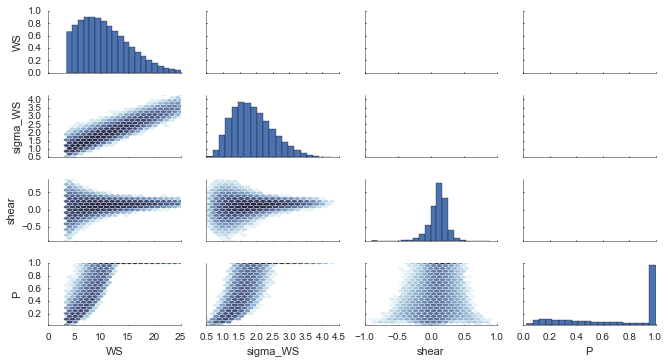

In [24]:
g = sns.PairGrid(df_sample,diag_sharey=False,size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20) 
g.savefig('Figures/8_WindEnergy_MC_sample.pdf')

### b) PCE point collocation

In [25]:
dist_train = cp.J(cp.Uniform(3.5,25.5),cp.Uniform(0.,4.5),cp.Uniform(-1.,1.))

In [26]:
D = 2
M = 4    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_train)

In [27]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_Q = dist_train.sample(int(6*special.comb(D+M+1,M+1)),rule='M')

print('nodes', len(nodes_Q[0,:]))

sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

df_nodes = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = nodes_Q.T)
#df_nodes['TI']=df_nodes.sigma_WS/df_nodes.WS
df_nodes['P'] = sample_u_pc

nodes 126


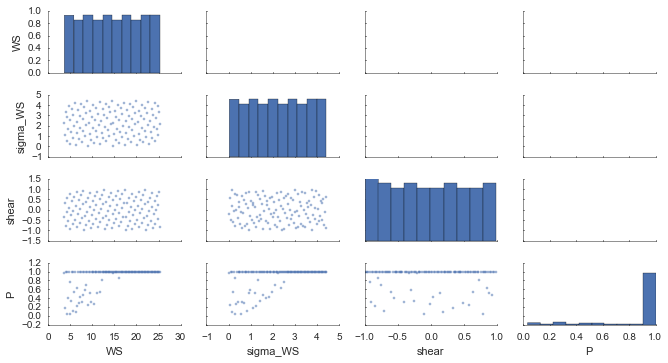

In [28]:
g = sns.PairGrid(df_nodes,diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/8b_WindEnergy_PCE_nodes.pdf')

35
(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(1, 1, 0)
(3, 1, 0)
(0, 1, 0)
(2, 1, 0)
(0, 2, 0)
(1, 2, 0)
(2, 2, 0)
(1, 3, 0)
(0, 3, 0)
(0, 4, 0)
(1, 0, 1)
(2, 0, 1)
(3, 0, 1)
(0, 1, 1)
(1, 1, 1)
(2, 1, 1)
(0, 2, 1)
(1, 2, 1)
(0, 0, 1)
(0, 3, 1)
(1, 0, 2)
(2, 0, 2)
(1, 1, 2)
(0, 1, 2)
(0, 2, 2)
(0, 0, 2)
(1, 0, 3)
(0, 0, 3)
(0, 0, 4)
(0, 0, 0)
(0, 1, 3)


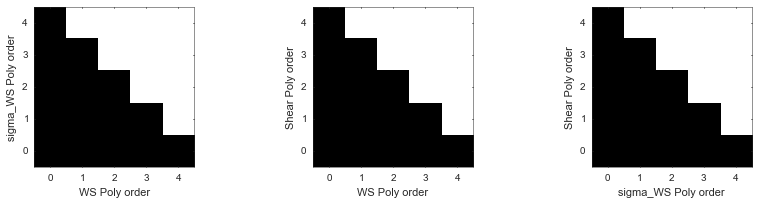

In [29]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_Q, sample_u_pc)#, 
                          #rule='LA',n_nonzero_coefs=100) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=M+1, tol=1e2) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          # -----------
                          # NOT sparse
                          # -----------
                          #rule='BARD')

# Statistics based on the PCE coefficients
#mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

print(len(u_hat.expons()))
if len(u_hat.expons())<100:
    for i in range(len(u_hat.expons())):
        print(u_hat.expons()[i]#, u_hat.coeffs()[i])

A=np.zeros([M+1]*3)
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)
plt.imshow(A[:,:,0].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('sigma_WS Poly order')

ax = fig.add_subplot(132)
plt.imshow(A[:,0,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('Shear Poly order')

ax = fig.add_subplot(133)
plt.imshow(A[0,:,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('sigma_WS Poly order')
ax.set_ylabel('Shear Poly order')

fig.tight_layout()
fig.savefig('Figures/8b_WindEnergy_PCE_sparse.pdf')

In [30]:
# Repeat the MC sample ussing the surrogate model
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_Q_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
# sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

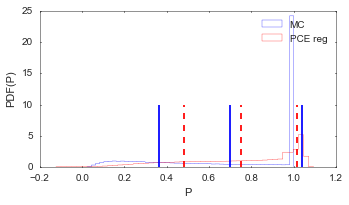

In [31]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE reg'
        )
plt.vlines([E_u_hat, E_u_hat-Std_u_hat, E_u_hat+Std_u_hat],0,10,'red','--')
#plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel('P')
ax.set_ylabel('PDF(P)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/8b_WindEnergy_PCE_P.pdf')
print()

In [32]:
df_sample_pc = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_Q_inputs.T)
#df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc['P'] = sample_u_hat

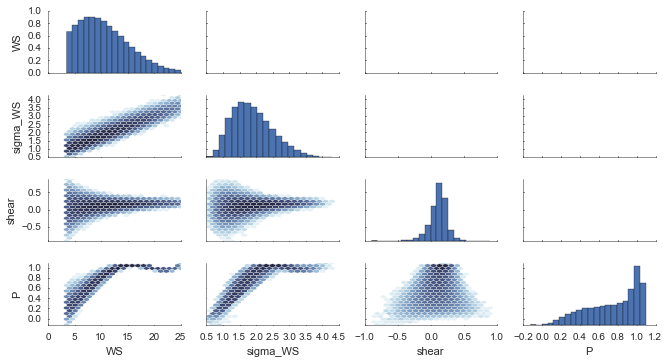

In [33]:
g = sns.PairGrid(df_sample_pc,diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/8b_WindEnergy_PCE_sample.pdf')

### c) PCE spectral projection

In [34]:
M = 6    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_train)

In [35]:
nodes, weights = cp.generate_quadrature(M+1, dist_train, rule='G')#, sparse=True)
    
Npc = len(weights)

sample_u_train = np.array([model(*node) for node in nodes.T])
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)
mean_u_pc, std_u_pc = cp.E(u_hat, dist_train), cp.Std(u_hat, dist_R)

df_nodes_sp = None
df_nodes_sp = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = nodes.T)
#df_nodes_sp['TI']= df_nodes_sp.sigma_WS/df_nodes_sp.WS
df_nodes_sp['P'] = sample_u_train

512


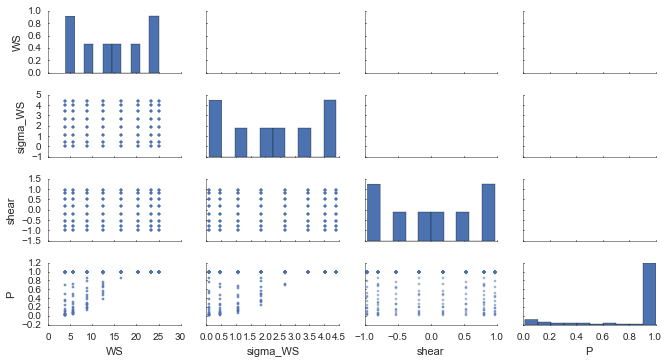

In [36]:
print(len(weights))

g = sns.PairGrid(df_nodes_sp,diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/8b_WindEnergy_PCE_nodes_sp.pdf')

In [37]:
# Repeat the MC sample ussing the surrogate model
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_Q_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
# sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

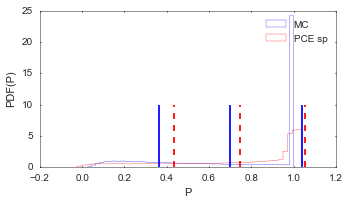

In [38]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE sp'
        )
plt.vlines([E_u_hat, E_u_hat-Std_u_hat, E_u_hat+Std_u_hat],0,10,'red','--')
#plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel('P')
ax.set_ylabel('PDF(P)')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/8b_WindEnergy_PCE_P_sp.pdf')
print()

In [39]:
df_sample_pc = None
df_sample_pc = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_Q_inputs.T)
#df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc['P'] = sample_u_hat

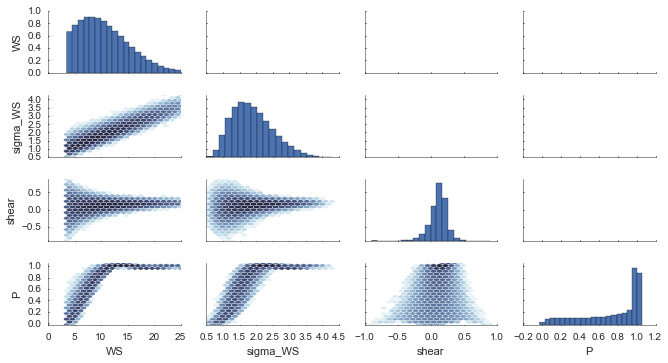

In [40]:
g = sns.PairGrid(df_sample_pc,diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/8b_WindEnergy_PCE_sample_sp.pdf')

### d) Convergence

In [180]:
#```Python
sample_inputs = dist_Q.sample(size=10**7,rule='H')
sample_u = model(*sample_inputs)

E_u_ref = np.mean(sample_u,axis=0)
Std_u_ref = np.std(sample_u,axis=0)
#```

```Python
M = 4
P = cp.orth_ttr(M,dist_R)
nodes_R, weights_R = cp.generate_quadrature(10**4, dist_R, rule='M')
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 

sample_u_train = np.array([model(*node) for node in nodes_Q.T])

u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)
Npc = len(weights_R)
print(Npc #len(P))

E_u_ref, Std_u_ref = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
#```

In [183]:
cp.fit_regression?

In [199]:
def PCE(M):
    # M: Order of the polynomial
    D = 3    # Number of dimensions

    P = cp.orth_ttr(M,dist_R)
    # Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
    Npc = int(3*special.comb(D+M+1,M+1)) #2**M-1#
    
    print(Npc)
    
    #nodes_R = dist_R.sample(Npc,rule='M') 
    nodes_R = pyDOE.lhs(n=D,samples=Npc, criterion='c').T
    
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
    sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

    u_hat = cp.fit_regression(P=P, x=nodes_R, u=sample_u_pc)
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    
    Error_E = np.abs(E_u_ref - mean_u_pc)/E_u
    Error_Std = np.abs(std_u_pc**2./Std_u_ref**2. - 1.)
    
    return Npc,Error_E, Error_Std

In [ ]:
order = range(2,10)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

60
105
168
252
360

In [196]:
def PCE_sp(M):
    # M: Order of the polynomial
    D = 3    # Number of dimensions
    
    P = cp.orth_ttr(M,dist_R)
    nodes_R, weights_R = cp.generate_quadrature(M+1, dist_R, rule='G')
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 

    sample_u_train = np.array([model(*node) for node in nodes_Q.T])
    
    u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)
    Npc = len(weights_R)
    print(Npc #len(P))
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    Error_E = np.abs(E_u_ref - mean_u_pc)/E_u
    Error_Std = np.abs(std_u_pc**2./Std_u_ref**2. - 1.)
    
    return Npc,Error_E, Error_Std

In [197]:
order   = range(2,10)
Npc_sp     = np.zeros(len(order))
Error_E_sp = np.zeros(len(order))
Error_Std_sp = np.zeros(len(order))

for i,M in enumerate(order):
    Npc_sp[i],Error_E_sp[i], Error_Std_sp[i] = PCE_sp(M)

64
125
216
343
512
729
1000
1331


In [188]:
def MC(Nmc):
    sample_inputs = dist_Q.sample(size=Nmc,rule='M')
    sample_u = np.array([model(*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.abs(E_u_ref - E_u_mc)/E_u
    Error_Std_mc = np.abs(Std_u_mc**2./Std_u_ref**2.-1.)
    
    return Error_E_mc, Error_Std_mc

In [189]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

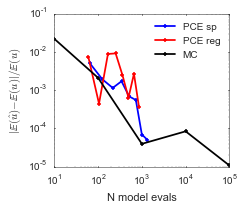

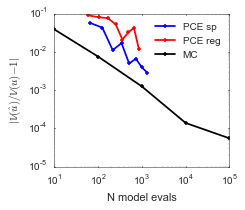

In [198]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc_sp,Error_E_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_E,'.-r',label='PCE reg')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/8_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc_sp,Error_Std_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_Std,'.-r',label='PCE reg')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/8_Convergence_V_'+output_name_label+'.pdf')